This is a CNN-LSTM implementation on AMAZON's news and charts data. Two Models are trained, one with the news sentiment data (VADER_Sentiment) and one without.

In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

Data Loading and Preprocessing

In [20]:
news_data = pd.read_csv('amazon_sentiment.csv')
data_2014 = pd.read_csv('AMAZON1440.csv')
data_2015 = pd.read_csv('AMAZON240.csv')
data_20173 = pd.read_csv('AMAZON60.csv')
data_20175 = pd.read_csv('AMAZON30.csv')
data_20179 = pd.read_csv('AMAZON15.csv')
data_201711 = pd.read_csv('AMAZON5.csv')

# Combine the datasets
combined_data = pd.concat([data_2014, data_2015, data_20173, data_20175, data_20179, data_201711], ignore_index=True)

# Normalize numerical features in news_data
scaler = StandardScaler()
news_data[['VADER_Sentiment']] = scaler.fit_transform(news_data[['VADER_Sentiment']])

# Convert 'Date' and 'Time' columns in combined_data to a datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'] + ' ' + combined_data['Time'])
combined_data = combined_data.drop(columns=['Time'])  
scaled_data = scaler.fit_transform(combined_data[['Open', 'Close', 'High', 'Low']])

# Convert 'Date' and 'Time' columns in news_data to a datetime format
news_data['Date'] = pd.to_datetime(news_data['Date'] + ' ' + news_data['Time'])
news_data = news_data.drop(columns=['Time','Title','Contents','Social_Popularity'])  

# Merge news and charts data
merged_data = pd.merge(news_data, combined_data, on='Date', how='inner')
merged_data['VADER_Sentiment'] = merged_data['VADER_Sentiment'].apply(lambda x: 1 if int(x) == 0 else -1)
merged_data['Sentiment']= merged_data['VADER_Sentiment']
merged_data = merged_data.drop(columns=['VADER_Sentiment'])

Making a combined Data Frame of News and Charts Data

In [21]:
df = merged_data
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,Close,High,Low,Volume,Sentiment
0,2017-12-28 00:00:00,1187.47,1189.98,1184.38,1185.10,15737,1
1,2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961,1
2,2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961,1
3,2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961,1
4,2018-01-02 00:00:00,1172.81,1189.75,1170.50,1186.00,20816,1
...,...,...,...,...,...,...,...
9620,2019-02-01 15:15:00,1652.98,1657.48,1652.03,1653.20,598,1
9621,2019-02-01 18:35:00,1641.44,1641.57,1638.54,1638.62,540,1
9622,2019-02-01 18:35:00,1641.44,1641.57,1638.54,1638.62,540,1
9623,2019-02-01 19:45:00,1629.43,1630.51,1626.59,1627.16,1951,1


Creating Training Data Frame with Selected Columns

In [23]:
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = [
    'Open',
    'Close',
    'High', 'Low',
    'Volume',
    'Sentiment'
        ]
print(cols)


df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'Close', 'High', 'Low', 'Volume', 'Sentiment']


,Open,Close,High,Low,Volume,Sentiment
Date,,,,,,
2017-12-28 00:00:00,1187.47,1189.98,1184.38,1185.10,15737.0,1.0
2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961.0,1.0
2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961.0,1.0
2017-12-29 00:00:00,1181.64,1183.80,1168.97,1169.47,18961.0,1.0
2018-01-02 00:00:00,1172.81,1189.75,1170.50,1186.00,20816.0,1.0
...,...,...,...,...,...,...
2019-02-01 15:15:00,1652.98,1657.48,1652.03,1653.20,598.0,1.0
2019-02-01 18:35:00,1641.44,1641.57,1638.54,1638.62,540.0,1.0
2019-02-01 18:35:00,1641.44,1641.57,1638.54,1638.62,540.0,1.0


Scaling of the Open And Close Values of the Training Data Frame

In [24]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Close']])

df_for_training_scaled

array([[0.01682447, 0.01802553, 0.01764329, 0.01780973, 0.28195159,
        1.        ],
       [0.0101337 , 0.01097057, 0.        , 0.        , 0.33971798,
        1.        ],
       [0.0101337 , 0.01097057, 0.        , 0.        , 0.33971798,
        1.        ],
       ...,
       [0.53782062, 0.53355099, 0.53762222, 0.53457686, 0.00965759,
        1.        ],
       [0.52403741, 0.52092514, 0.52394037, 0.52151867, 0.03493935,
        1.        ],
       [0.52403741, 0.52092514, 0.52527993, 0.52298857, 0.01051764,
        1.        ]])

Creating Train Input features and Target Variables

In [28]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    # Extract the relevant columns for the input sequence (trainX)
    X_sequence = df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]]  # Open, Close, High, Low, Volume, VADER
    trainX.append(X_sequence)

    # Extract the target values (trainY)
    y_sample = df_for_training_scaled[i + n_future - 1:i + n_future, [1, 2]]  # Open, Close
    trainY.append(y_sample)

trainX, trainY = np.array(trainX), np.array(trainY)


print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (9620, 5, 6).
TrainY shape = (9620, 1, 2).


Train data with and without Sentiment

In [29]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_sentiment, X_test_lstm_without_sentiment, y_train_lstm_without_sentiment, y_test_lstm_without_sentiment = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_sentiment, X_test_lstm_sentiment, y_train_lstm_sentiment, y_test_lstm_sentiment = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_sentiment.shape,X_train_lstm_sentiment.shape

((7696, 5, 5), (7696, 5, 6))

Validation data with and without Sentiment

In [30]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_sentiment, X_val_lstm_without_sentiment, y_train_lstm_without_sentiment, y_val_lstm_without_sentiment = train_test_split(X_train_lstm_without_sentiment, y_train_lstm_without_sentiment, test_size=0.1, shuffle=False)

X_train_lstm_sentiment, X_val_lstm_sentiment, y_train_lstm_sentiment, y_val_lstm_sentiment = train_test_split(X_train_lstm_sentiment, y_train_lstm_sentiment, test_size=0.1, shuffle=False)

X_train_lstm_without_sentiment.shape,X_train_lstm_sentiment.shape

((6926, 5, 5), (6926, 5, 6))

CNN-LSTM Model

In [32]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

Training / Fitting the model with and without sentiment data

In [46]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping if validation loss remains unchanged
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
cnn_lstm_model_without_sentiment=build_model((X_train_lstm_without_sentiment.shape[1],X_train_lstm_without_sentiment.shape[2]))
cnn_lstm_model_sentiment=build_model((X_train_lstm_sentiment.shape[1],X_train_lstm_sentiment.shape[2]))

history_without_sentiment = cnn_lstm_model_without_sentiment.fit(X_train_lstm_without_sentiment, y_train_lstm_without_sentiment, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_sentiment, y_val_lstm_without_sentiment), verbose=1,callbacks=[early_stopping] )

history_sentiment = cnn_lstm_model_sentiment.fit(X_train_lstm_sentiment, y_train_lstm_sentiment, epochs=50, batch_size=64, validation_data=(X_val_lstm_sentiment, y_val_lstm_sentiment), verbose=1,callbacks=[early_stopping] )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 128)            1408      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 512)            657408    
 onal)                                                           
                                                      

Training loss and Validation loss without sentiment data

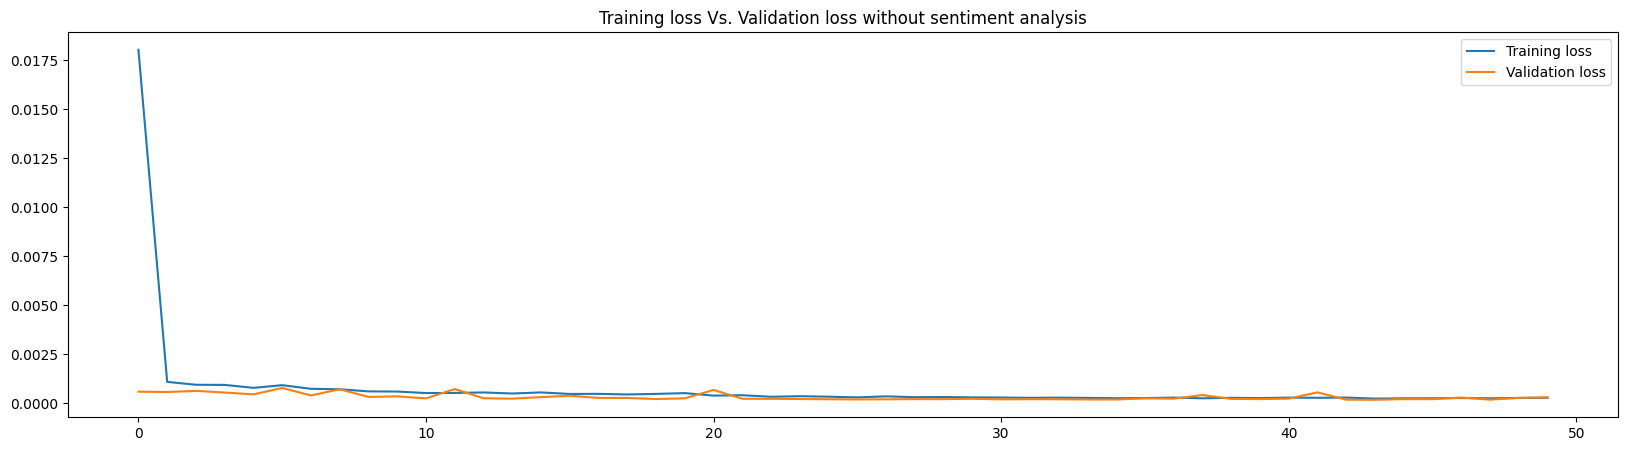

In [47]:
plt.figure(figsize=(20,5))
plt.plot(history_without_sentiment.history['loss'], label='Training loss')
plt.plot(history_without_sentiment.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without sentiment analysis')
plt.legend()

Training loss and Validation loss with sentiment data

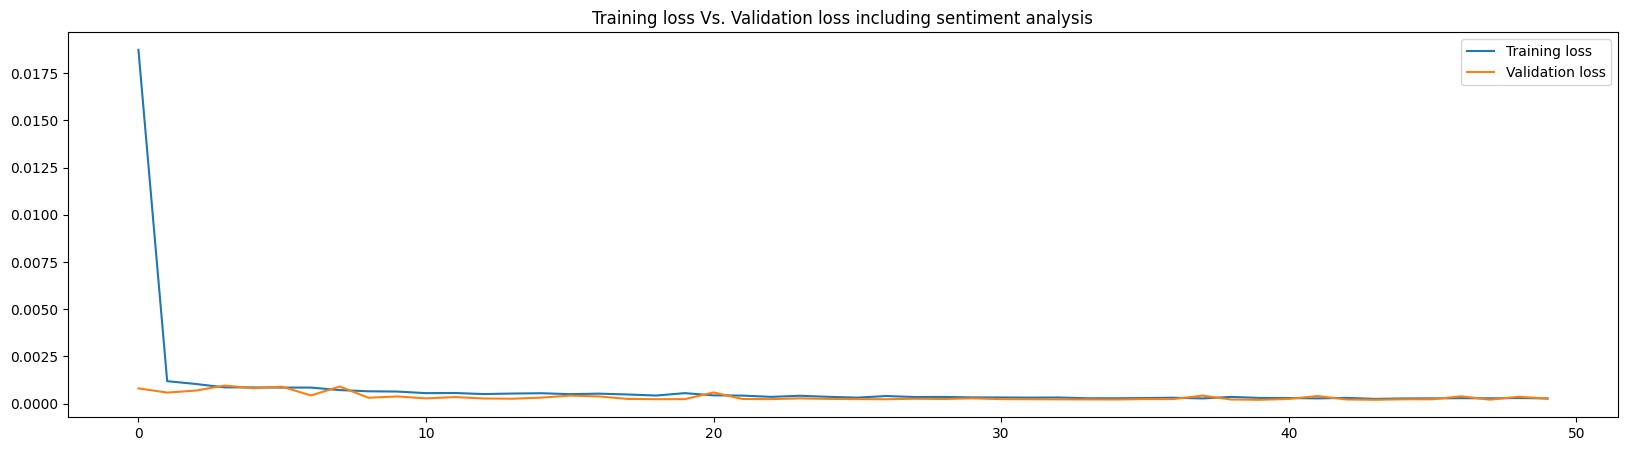

In [48]:
plt.figure(figsize=(20,5))
plt.plot(history_sentiment.history['loss'], label='Training loss')
plt.plot(history_sentiment.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including sentiment analysis')
plt.legend()

Plotting the predictions with or without sentiment data

In [49]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,sentiment,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if sentiment :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

Prediction on Train Data. The metrics for the prediction is Mean Squared Error

In [50]:
training_dates= df_for_training.index[:X_train_lstm_without_sentiment.shape[0]]
#Make prediction
training_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_train_lstm_without_sentiment)

training_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_train_lstm_sentiment)

training_prediction_without_sentiment=training_prediction_without_sentiment.reshape(training_prediction_without_sentiment.shape[0], training_prediction_without_sentiment.shape[2])

training_prediction_sentiment=training_prediction_sentiment.reshape(training_prediction_sentiment.shape[0], training_prediction_sentiment.shape[2])

y_train_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(training_prediction_without_sentiment)

y_train_pred_lstm_sentiment = scaler_for_inference.inverse_transform(training_prediction_sentiment)

y_train_lstm_reshaped_without_sentiment=y_train_lstm_without_sentiment.reshape(y_train_lstm_without_sentiment.shape[0], y_train_lstm_without_sentiment.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_sentiment)

217/217 [==============================] - 4s 9ms/step


Training Prediction without sentiment data

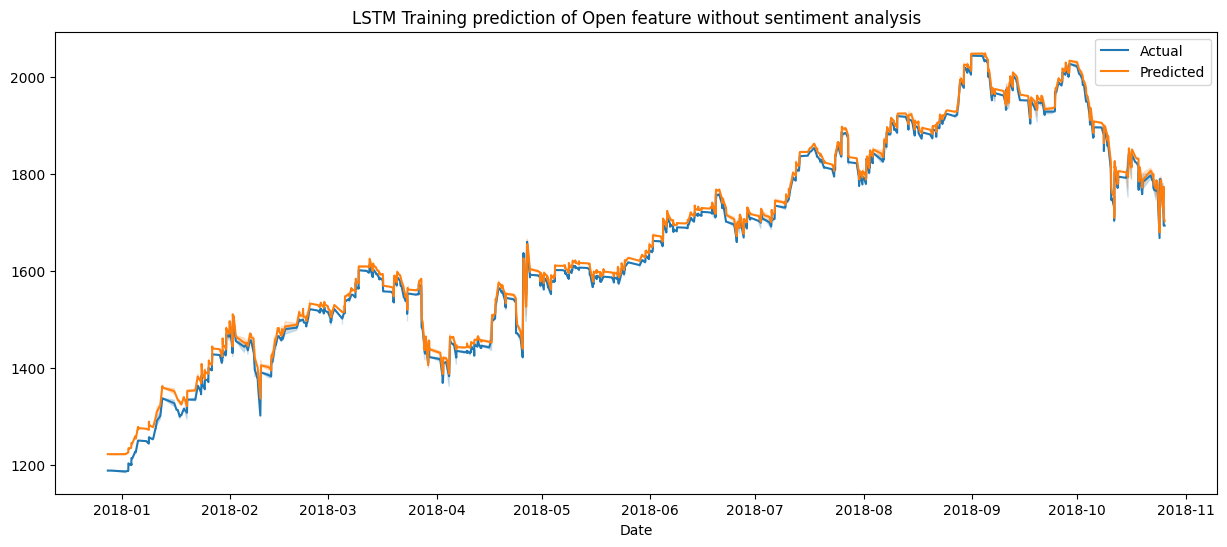

Mean square error for Open =201.21970940798758


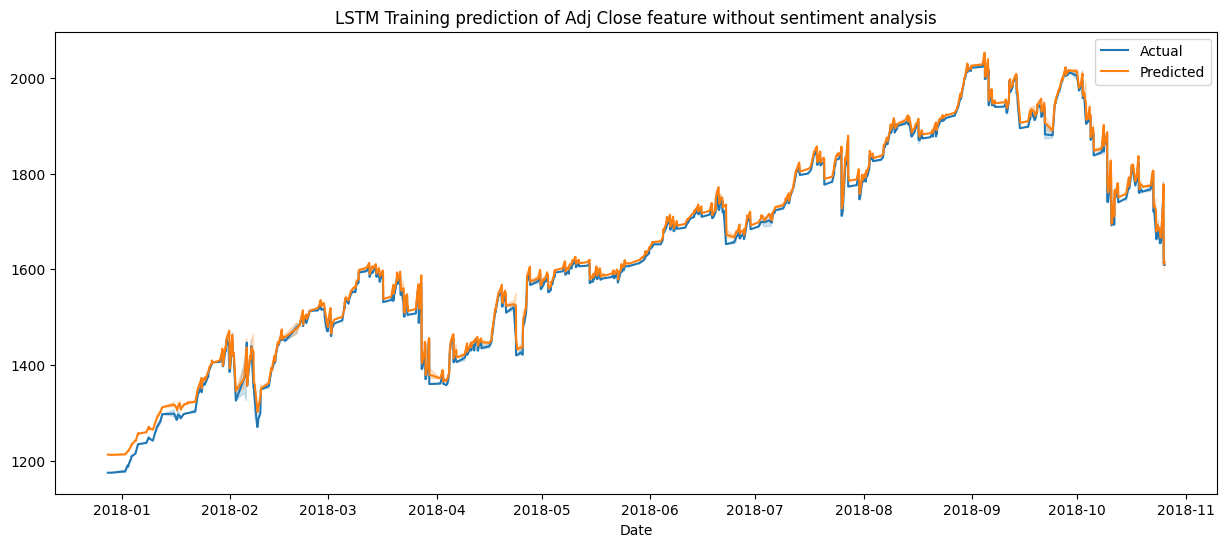

Mean square error for Adj Close =198.02895503564542
Total mean square error 199.6243322218174


In [51]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_sentiment)

Training Prediction with sentiment data

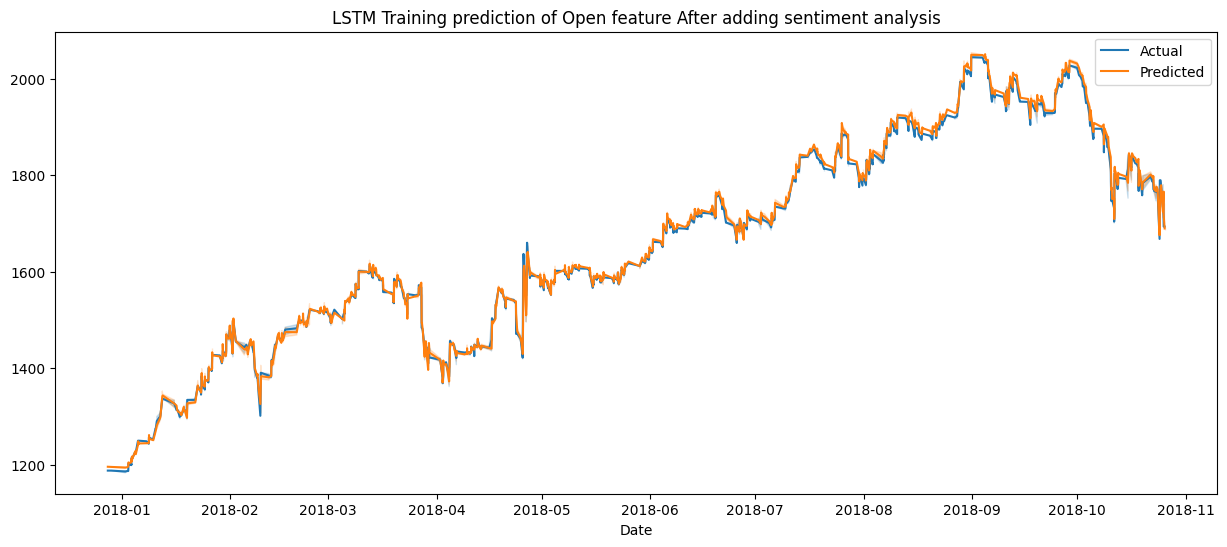

Mean square error for Open =106.34574107569259


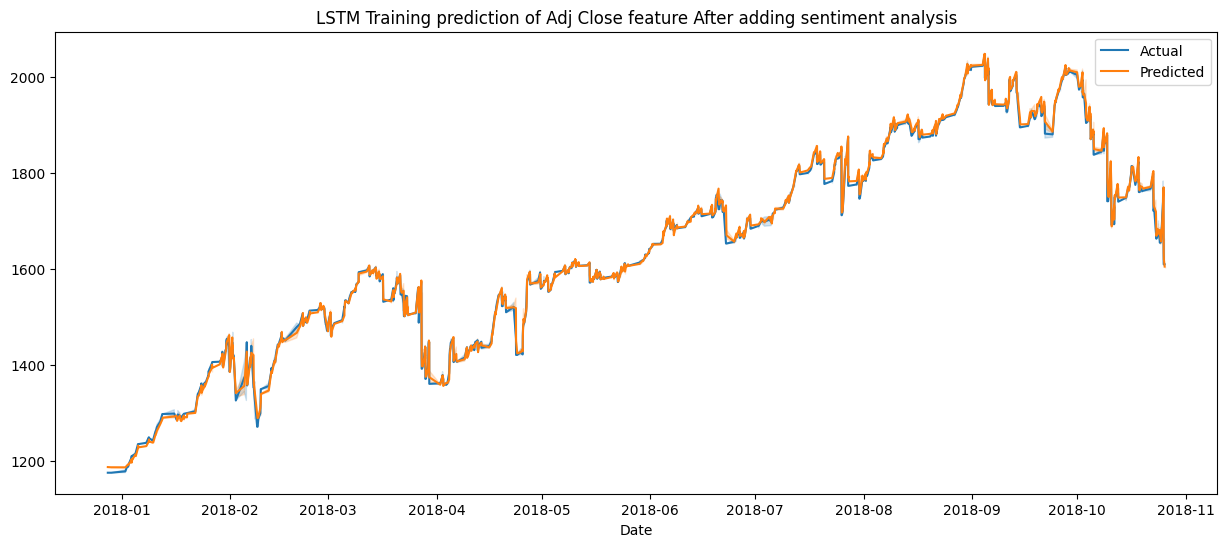

Mean square error for Adj Close =123.41326875033987
Total mean square error 114.87950491301618


In [52]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_sentiment)

Prediction on Validation Data. The metrics for the prediction is Mean Squared Error

In [53]:
validation_dates= df_for_training.index[X_train_lstm_without_sentiment.shape[0]:X_train_lstm_without_sentiment.shape[0] + X_val_lstm_without_sentiment.shape[0]]
#Make prediction
validation_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_val_lstm_without_sentiment)

validation_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_val_lstm_sentiment)

validation_prediction_without_sentiment=validation_prediction_without_sentiment.reshape(validation_prediction_without_sentiment.shape[0], validation_prediction_without_sentiment.shape[2])


validation_prediction_sentiment=validation_prediction_sentiment.reshape(validation_prediction_sentiment.shape[0], validation_prediction_sentiment.shape[2])


y_val_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(validation_prediction_without_sentiment)
y_val_pred_lstm_sentiment = scaler_for_inference.inverse_transform(validation_prediction_sentiment)

y_val_actual_lstm_reshaped_without_sentiment=y_val_lstm_without_sentiment.reshape(y_val_lstm_without_sentiment.shape[0], y_val_lstm_without_sentiment.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_sentiment)

25/25 [==============================] - 0s 10ms/step


Validation Prediction without sentiment data

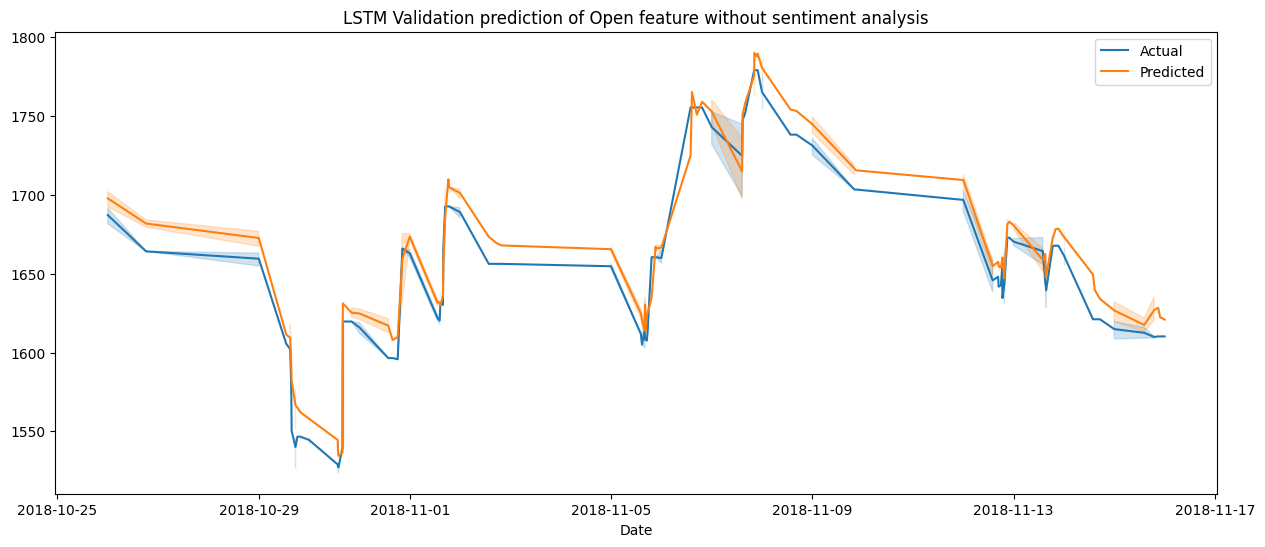

Mean square error for Open =216.72355406066833


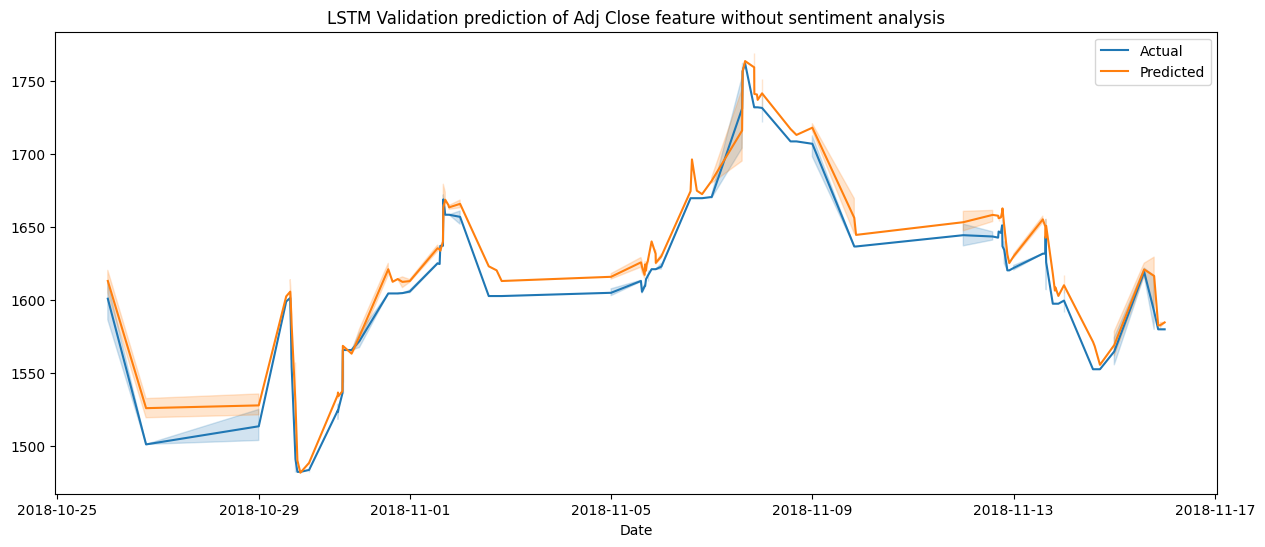

Mean square error for Adj Close =259.2742592620447
Total mean square error 237.99890666135605


In [54]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_sentiment)

Validation Prediction with sentiment data

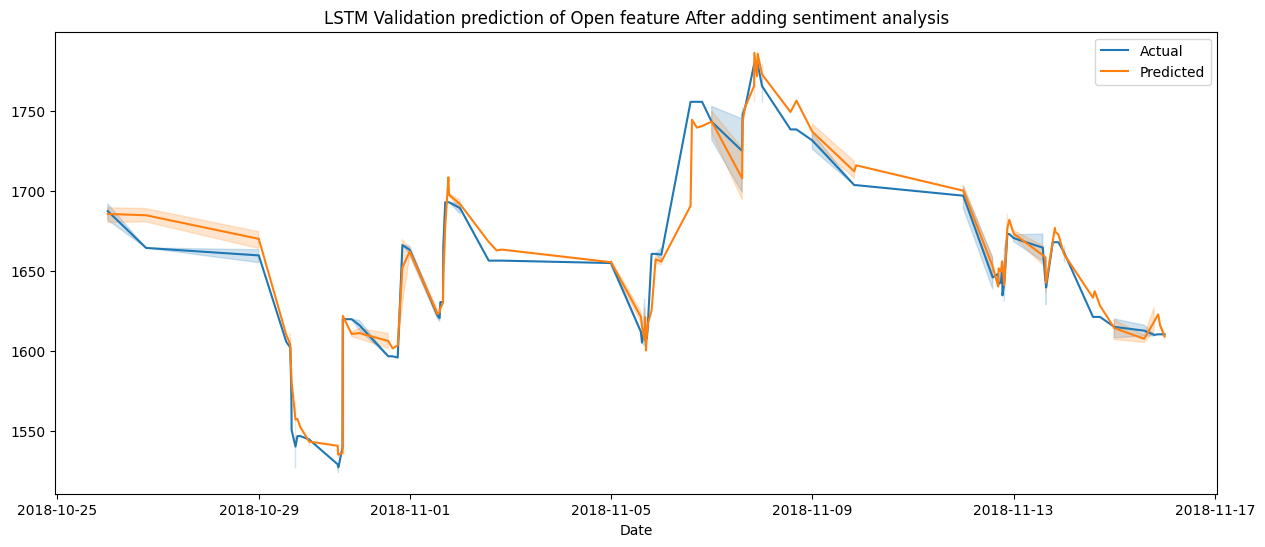

Mean square error for Open =129.50652284109674


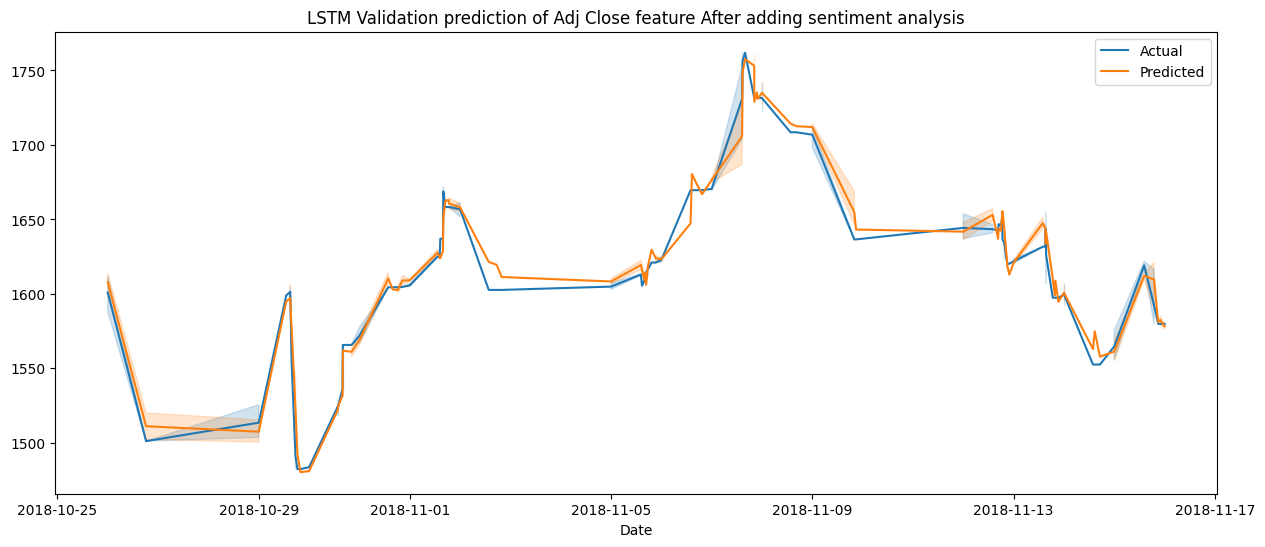

Mean square error for Adj Close =187.6257454430735
Total mean square error 158.56613414208493


In [55]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_sentiment)

Prediction on Test Data. The metrics for the prediction is Mean Squared Error

In [56]:
testing_dates= df_for_training.index[-X_test_lstm_without_sentiment.shape[0]:]
#Make prediction
testing_prediction_without_sentiment = cnn_lstm_model_without_sentiment.predict(X_test_lstm_without_sentiment)
testing_prediction_sentiment = cnn_lstm_model_sentiment.predict(X_test_lstm_sentiment)

testing_prediction_without_sentiment=testing_prediction_without_sentiment.reshape(testing_prediction_without_sentiment.shape[0], testing_prediction_without_sentiment.shape[2])
testing_prediction_sentiment=testing_prediction_sentiment.reshape(testing_prediction_sentiment.shape[0], testing_prediction_sentiment.shape[2])

y_test_pred_lstm_without_sentiment = scaler_for_inference.inverse_transform(testing_prediction_without_sentiment)
y_test_pred_lstm_sentiment = scaler_for_inference.inverse_transform(testing_prediction_sentiment)

y_test_actual_lstm_reshaped_without_sentiment=y_test_lstm_without_sentiment.reshape(y_test_lstm_without_sentiment.shape[0], y_test_lstm_without_sentiment.shape[2])

y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_sentiment)

61/61 [==============================] - 1s 10ms/step


Testing Prediction without sentiment data

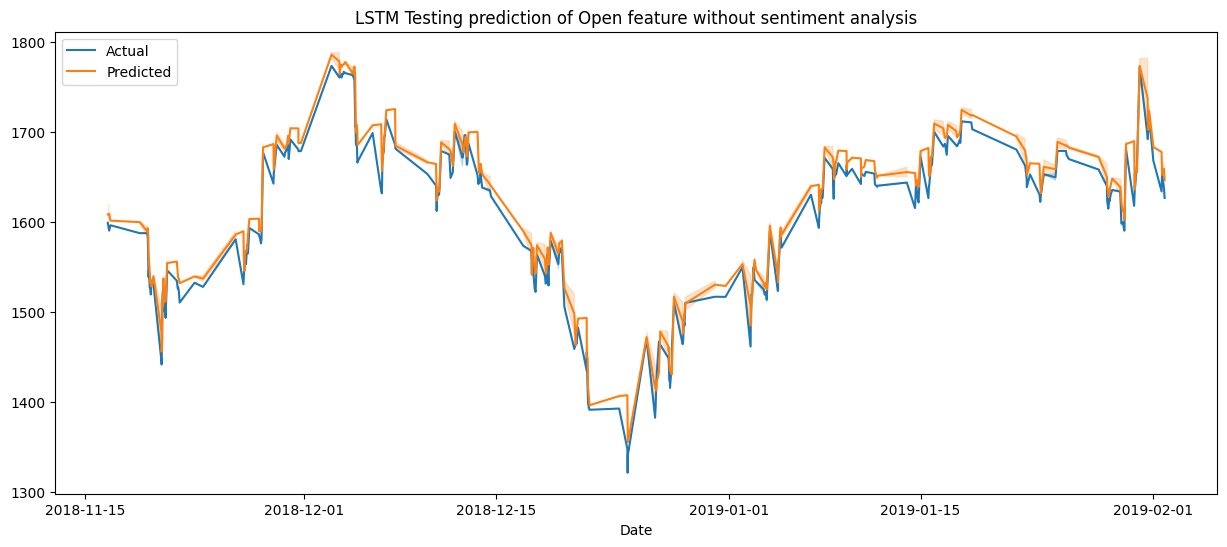

Mean square error for Open =256.24567737778455


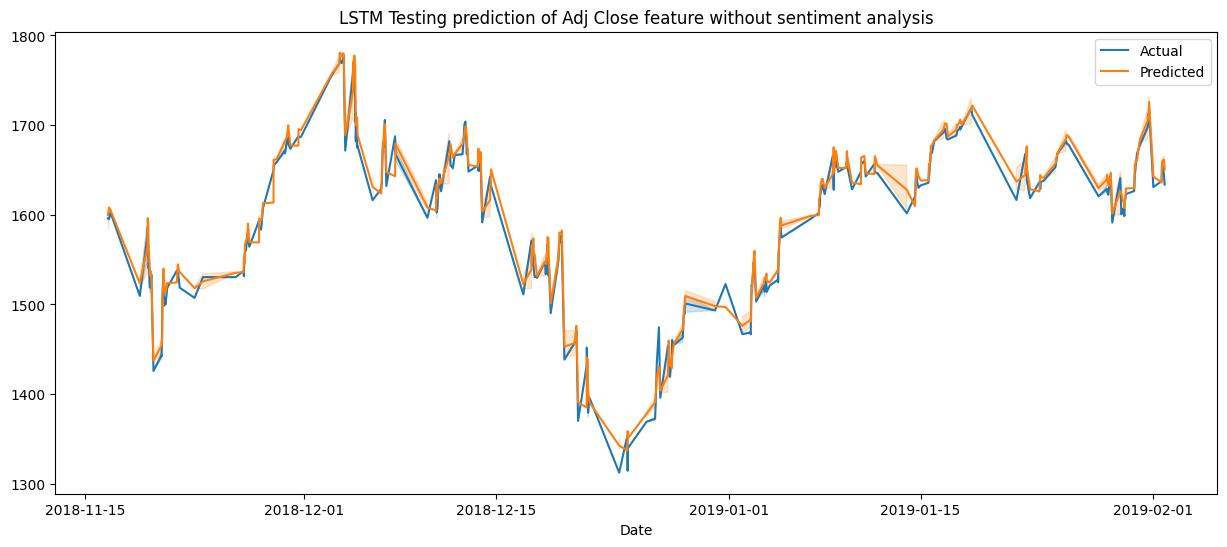

Mean square error for Adj Close =221.8094404941062
Total mean square error 239.02755893594554


In [57]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_sentiment)

Testing Prediction with sentiment data

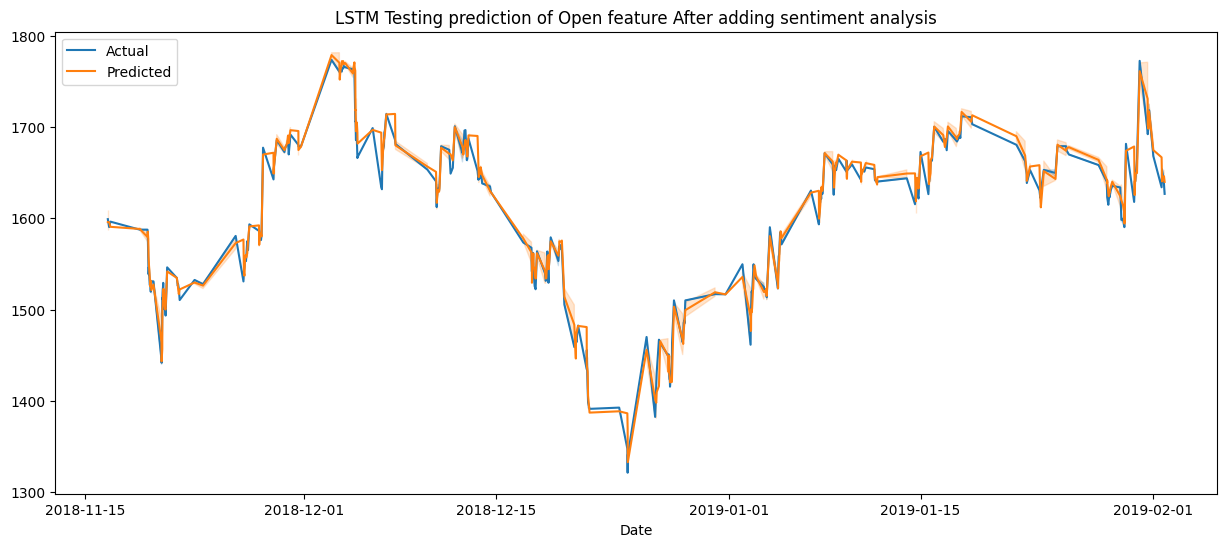

Mean square error for Open =163.7351692926507


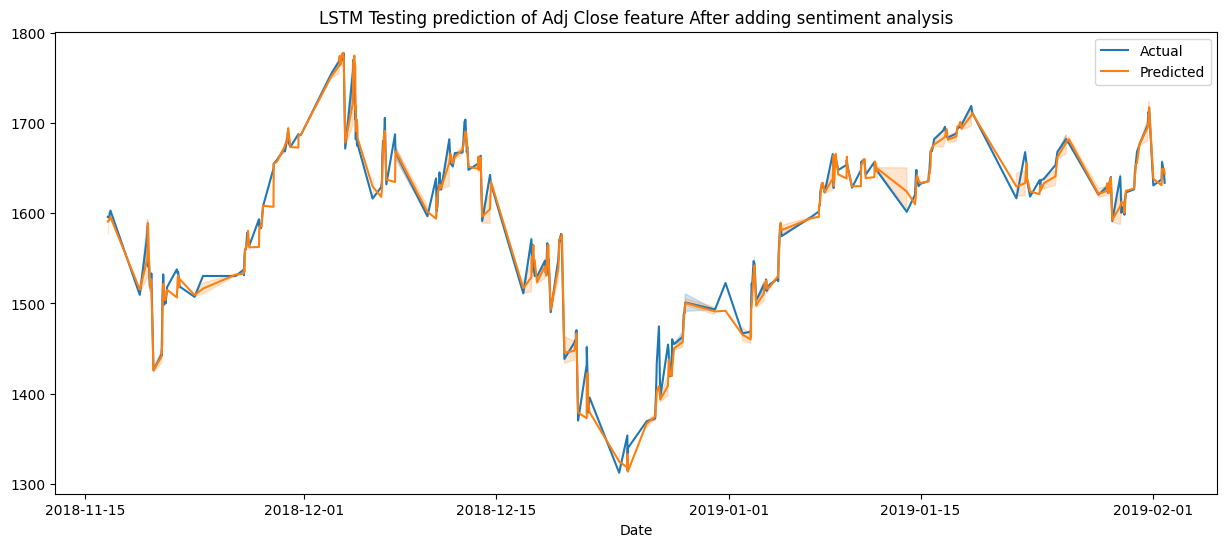

Mean square error for Adj Close =167.35342855309923
Total mean square error 165.54429892287538


In [58]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_sentiment)